In [8]:
# dtcformer_adni_pytorch.py
import torch
import torch.nn as nn
import torch.optim as optim  # <--- add this
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import pydicom
import numpy as np
from tqdm import tqdm
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

In [9]:
import os

# Show all datasets uploaded to Kaggle notebook
print("Available folders inside /kaggle/input:")
folders = os.listdir("/kaggle/input")
print(folders)

Available folders inside /kaggle/input:
['adni-dataset']


In [10]:
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = {
    "input_shape": (128, 128, 128),
    "batch_size": 2,
    "epochs": 60,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "num_workers": 4,
    "patience": 12,
    "bottleneck_channels": 128,
    "base_filters": 32
}

print("DEVICE:", DEVICE)
print("CONFIG:", CONFIG)

DEVICE: cpu
CONFIG: {'input_shape': (128, 128, 128), 'batch_size': 2, 'epochs': 60, 'lr': 0.0001, 'weight_decay': 1e-05, 'num_workers': 4, 'patience': 12, 'bottleneck_channels': 128, 'base_filters': 32}


In [13]:
import random
import numpy as np
import torch

SEED = 42

def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

seed_all()

In [15]:
from typing import List
from torch.utils.data import Dataset
import numpy as np
import nibabel as nib
import torch

class ADNIDataset(Dataset):
    def __init__(self, paths: List[str], labels: List[int], input_shape=(128,128,128), transform=None):
        assert len(paths) == len(labels)
        self.paths = paths
        self.labels = labels
        self.input_shape = input_shape
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        img = nib.load(img_path).get_fdata()

        # Resize or crop if required
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            img = self.transform(img)

        return img, label

In [16]:
class ADNIDataset(Dataset):
    def __init__(self, paths: List[str], labels: List[int], input_shape=(128,128,128), transform=None):
        assert len(paths) == len(labels)
        self.paths = paths
        self.labels = labels
        self.input_shape = input_shape
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def load_nifti(self, path):
        img = nib.load(path)
        arr = img.get_fdata(dtype=np.float32)
        # if 4D, take first volume
        if arr.ndim == 4:
            arr = arr[...,0]
        return arr

    def center_crop_or_pad(self, vol):
        D0,H0,W0 = vol.shape
        D,H,W = self.input_shape
        # crop if larger
        start_d = max((D0 - D)//2, 0)
        start_h = max((H0 - H)//2, 0)
        start_w = max((W0 - W)//2, 0)
        if D0 >= D and H0 >= H and W0 >= W:
            vol = vol[start_d:start_d+D, start_h:start_h+H, start_w:start_w+W]
        else:
            # pad
            pad_d = max(D - D0, 0)
            pad_h = max(H - H0, 0)
            pad_w = max(W - W0, 0)
            pad_before = (pad_d//2, pad_h//2, pad_w//2)
            pad_after = (pad_d - pad_before[0], pad_h - pad_before[1], pad_w - pad_before[2])
            pads = ((pad_before[0], pad_after[0]), (pad_before[1], pad_after[1]), (pad_before[2], pad_after[2]))
            vol = np.pad(vol, pads, mode='constant', constant_values=0)
        return vol

    def normalize(self, vol):
        m = vol.mean()
        s = vol.std()
        if s < 1e-6:
            s = 1.0
        vol = (vol - m) / s
        return vol

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = int(self.labels[idx])
        vol = self.load_nifti(path)
        vol = self.center_crop_or_pad(vol)
        vol = self.normalize(vol)
        # optional augmentations can be applied here
        vol = vol.astype(np.float32)
        vol = np.expand_dims(vol, axis=0)  # channel dim
        return torch.from_numpy(vol), torch.tensor(label, dtype=torch.long)


In [17]:
# Model building blocks
# -------------------------
def conv3d_bn_relu(in_ch, out_ch, kernel=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv3d(in_ch, out_ch, kernel, stride=stride, padding=padding, bias=False),
        nn.BatchNorm3d(out_ch),
        nn.ReLU(inplace=True)
    )

class ResidualBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = conv3d_bn_relu(in_ch, out_ch, kernel=3, stride=stride)
        self.conv2 = nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_ch)
        if downsample or in_ch != out_ch:
            self.down = nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_ch)
            )
        else:
            self.down = None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.down is not None:
            identity = self.down(identity)
        out += identity
        return self.relu(out)

class ResNet3DBackbone(nn.Module):
    def __init__(self, in_ch=1, base_filters=32):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(in_ch, base_filters, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = nn.Sequential(ResidualBlock3D(base_filters, base_filters), ResidualBlock3D(base_filters, base_filters))
        self.layer2 = nn.Sequential(ResidualBlock3D(base_filters, base_filters*2, downsample=True), ResidualBlock3D(base_filters*2, base_filters*2))
        self.layer3 = nn.Sequential(ResidualBlock3D(base_filters*2, base_filters*4, downsample=True), ResidualBlock3D(base_filters*4, base_filters*4))
        self.layer4 = nn.Sequential(ResidualBlock3D(base_filters*4, base_filters*8, downsample=True), ResidualBlock3D(base_filters*8, base_filters*8))
        # final channels
        self.out_channels = base_filters * 8

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x  # shape [B, C, D', H', W']

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from scipy.ndimage import affine_transform, gaussian_filter

class Random3DAugment:
    def __init__(self, noise_std=0.1, rotate_deg=10, scale_range=(0.9, 1.1)):
        self.noise_std = noise_std
        self.rotate_deg = rotate_deg
        self.scale_range = scale_range

    def random_affine(self, img):
        angle = np.deg2rad(random.uniform(-self.rotate_deg, self.rotate_deg))
        scale = random.uniform(*self.scale_range)

        rotation_matrix = np.array([
            [np.cos(angle)*scale, -np.sin(angle)*scale, 0],
            [np.sin(angle)*scale,  np.cos(angle)*scale, 0],
            [0, 0, scale]
        ])

        img = affine_transform(img, rotation_matrix, order=1)
        return img

    def random_noise(self, img):
        noise = np.random.normal(0, self.noise_std, img.shape)
        return img + noise

    def __call__(self, tensor):
        img = tensor.squeeze(0).numpy()  # (D,H,W)

        img = self.random_affine(img)
        img = self.random_noise(img)

        return torch.tensor(img).unsqueeze(0).float()

In [21]:
class MRIDataset(Dataset):
    def __init__(self, paths, labels, transform=None, target_shape=(128,128,128)):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.target_shape = target_shape

    def __getitem__(self, idx):
        img = load_nii(self.paths[idx])       # your loading function
        img = resize_to_target(img, self.target_shape)

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [23]:
import os

dataset_path = '/kaggle/input/adni-dataset'  # change this
extensions = set()

for root, dirs, files in os.walk(dataset_path):
    for f in files:
        ext = os.path.splitext(f)[1]
        extensions.add(ext.lower())

print("File extensions in dataset:", extensions)

File extensions in dataset: {'.dcm'}


Found 1852 DICOM files.


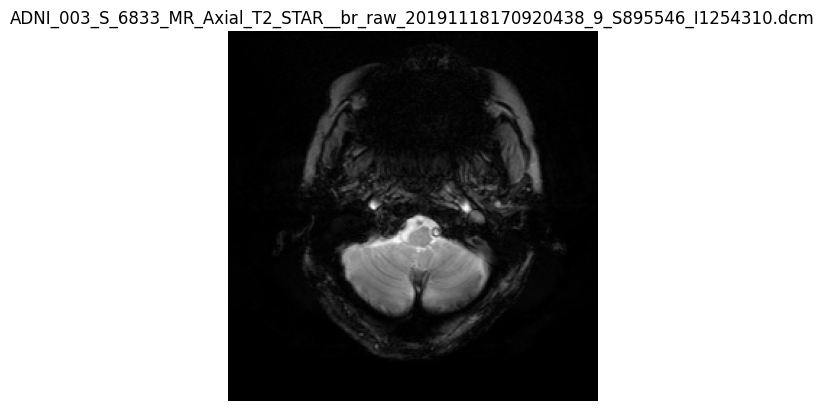

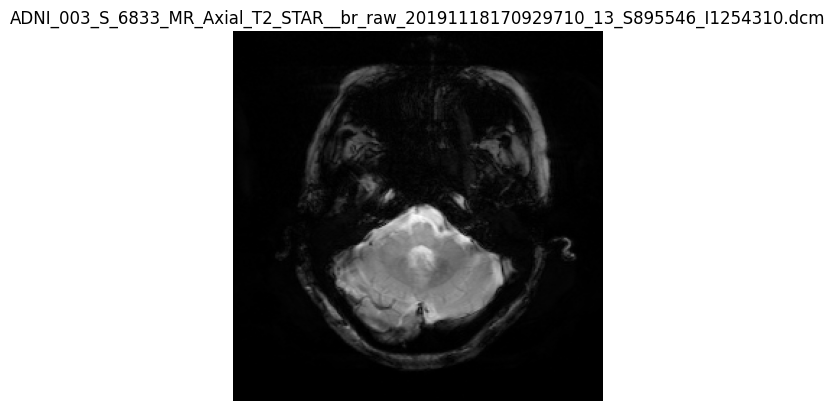

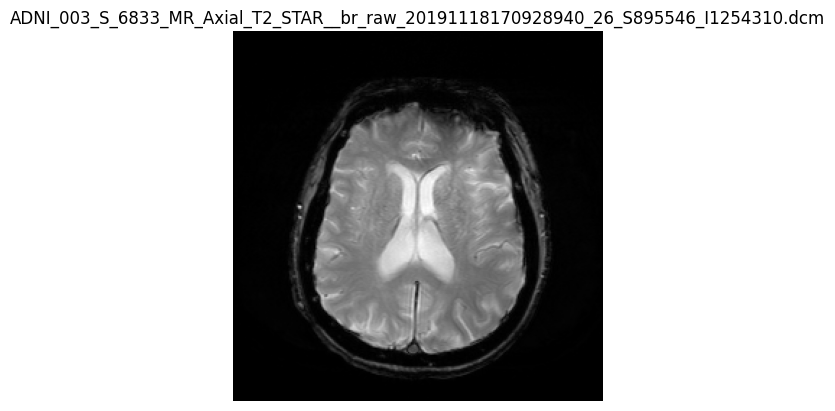

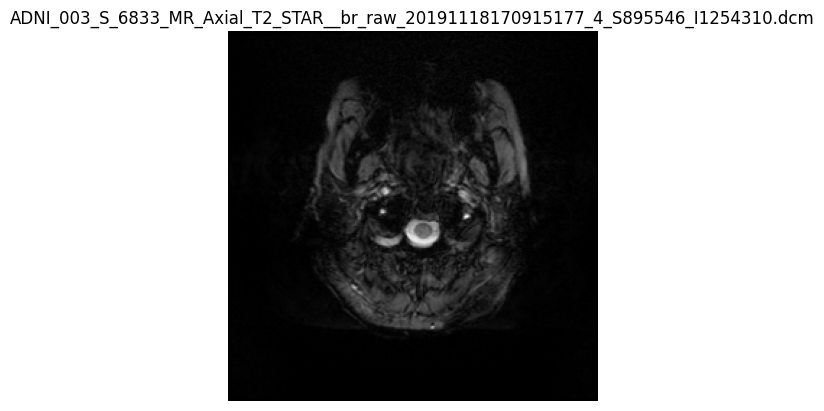

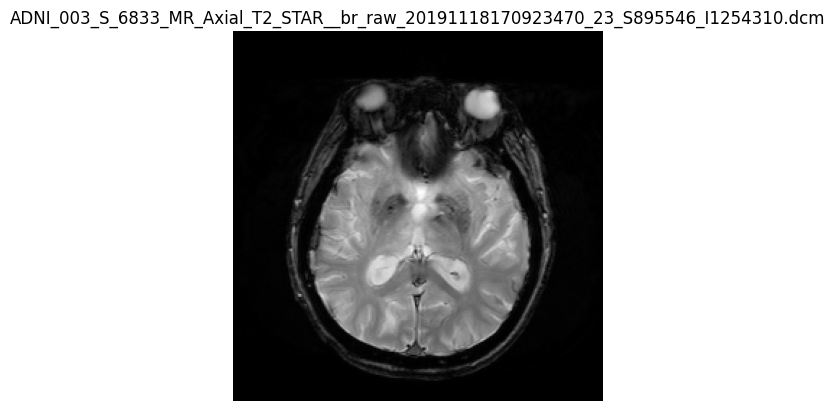

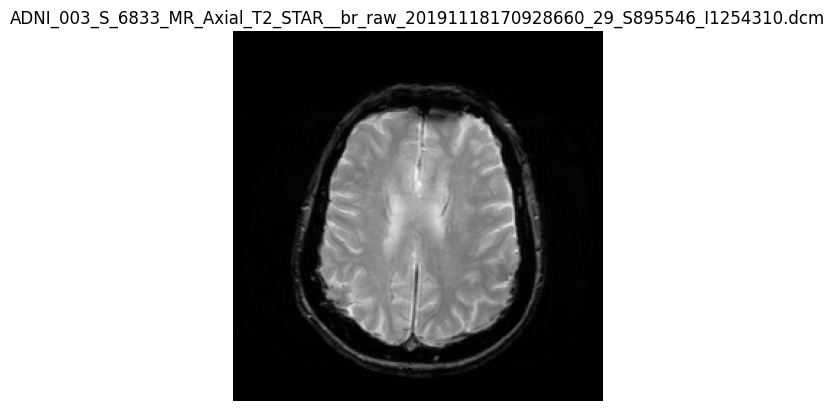

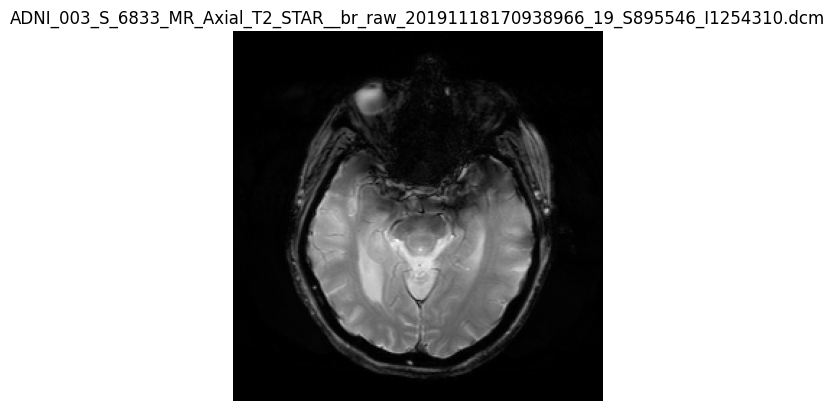

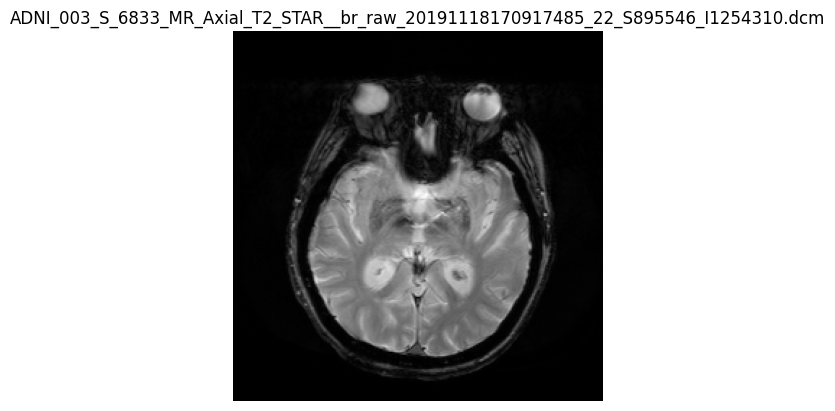

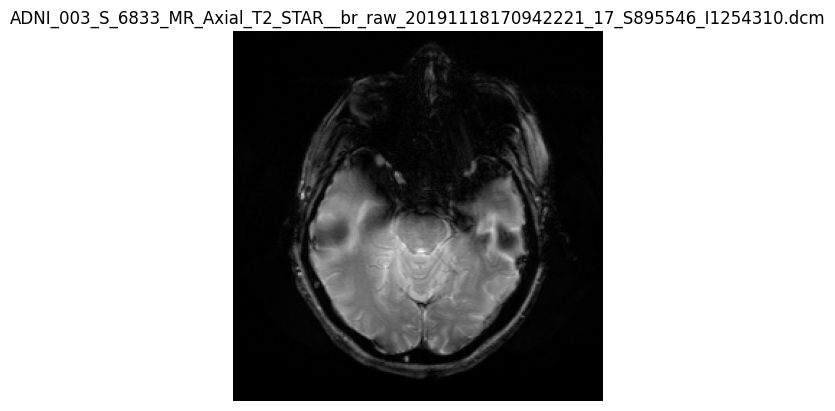

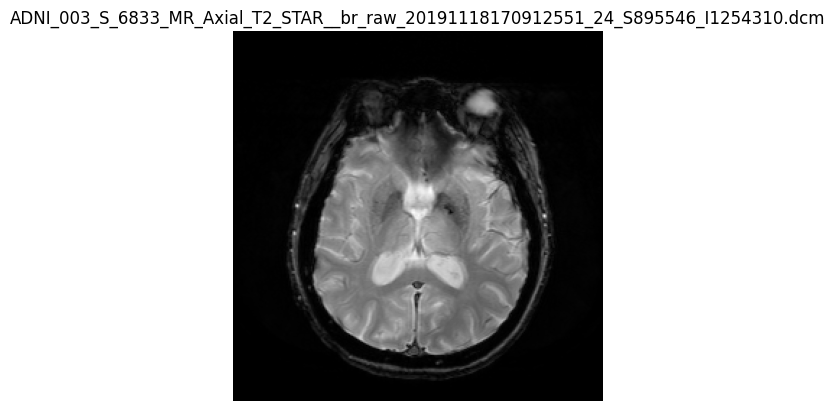

In [24]:
import pydicom
import matplotlib.pyplot as plt
from glob import glob
import os

dataset_path = '/kaggle/input/adni-dataset'
dicom_files = glob(os.path.join(dataset_path, '**', '*.dcm'), recursive=True)

if len(dicom_files) == 0:
    print("No DICOM files found!")
else:
    print(f"Found {len(dicom_files)} DICOM files.")

    # Display first 3 DICOM images
    for dicom_file in dicom_files[:10]:
        ds = pydicom.dcmread(dicom_file)
        plt.imshow(ds.pixel_array, cmap='gray')
        plt.title(os.path.basename(dicom_file))
        plt.axis('off')
        plt.show()

In [45]:
# TCDM approximation: learnable bottleneck
# -------------------------
class TensorBottleneck(nn.Module):
    def __init__(self, in_ch, bottleneck_ch=128, groups=8):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, bottleneck_ch, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(bottleneck_ch)
        self.relu = nn.ReLU(inplace=True)
        self.groups = groups
        # grouped conv for expressiveness
        if bottleneck_ch % groups == 0:
            self.group_conv = nn.Conv3d(bottleneck_ch, bottleneck_ch, kernel_size=3, padding=1, groups=groups, bias=False)
        else:
            self.group_conv = nn.Conv3d(bottleneck_ch, bottleneck_ch, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(bottleneck_ch)
        # output projection (keep bottleneck dim for classifier)
        # Optionally project back to original in_ch if you want a residual path
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.group_conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x  # shape [B, bottleneck_ch, D', H', W']

In [25]:
# Intra-latent Self-Attention (ILSF)
# -------------------------
class IntraLatentSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, dim)
        )

    def forward(self, x):
        # x: [B, C, D, H, W] -> tokens
        B, C, D, H, W = x.shape
        tokens = x.view(B, C, -1).permute(0,2,1)  # [B, N, C]
        tokens_norm = self.ln1(tokens)
        attn_out, _ = self.mha(tokens_norm, tokens_norm, tokens_norm)
        tokens = tokens + attn_out
        tokens = tokens + self.ff(self.ln2(tokens))
        # reshape back
        out = tokens.permute(0,2,1).view(B, C, D, H, W)
        return out

# -------------------------
# Feature Purification Module (FPM) - high-pass residual
# -------------------------
class FeaturePurification(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # 3x3x3 convolution acting as learnable high-pass filter
        self.conv = nn.Conv3d(channels, channels, kernel_size=3, padding=1, groups=1, bias=False)
        self.bn = nn.BatchNorm3d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        hp = self.conv(x)
        hp = self.bn(hp)
        hp = self.relu(hp)
        return x + hp  # residual sharpen

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Minimal ResNet3D-like backbone
class ResNet3DBackbone(nn.Module):
    def __init__(self, in_ch=1, base_filters=32):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, base_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(base_filters)
        self.conv2 = nn.Conv3d(base_filters, base_filters*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(base_filters*2)
        self.out_channels = base_filters*2
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

# Simple bottleneck
class TensorBottleneck(nn.Module):
    def __init__(self, in_ch, bottleneck_ch=128):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, bottleneck_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# Dummy self-attention (just identity for simplicity)
class IntraLatentSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4, ff_dim=None):
        super().__init__()
    def forward(self, x):
        return x  # identity, replace with attention later

# Dummy feature purification
class FeaturePurification(nn.Module):
    def __init__(self, dim):
        super().__init__()
    def forward(self, x):
        return x  # identity

# Your DTCFormer3D model
class DTCFormer3D(nn.Module):
    def __init__(self, in_ch=1, base_filters=32, bottleneck_ch=128, num_classes=2):
        super().__init__()
        self.backbone = ResNet3DBackbone(in_ch=in_ch, base_filters=base_filters)
        in_channels = self.backbone.out_channels
        self.tcdm = TensorBottleneck(in_channels, bottleneck_ch=bottleneck_ch)
        self.il = IntraLatentSelfAttention(dim=bottleneck_ch, num_heads=4, ff_dim=bottleneck_ch*2)
        self.fpm = FeaturePurification(bottleneck_ch)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(bottleneck_ch, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        feat = self.backbone(x)
        bott = self.tcdm(feat)
        attn = self.il(bott)
        fused = attn
        pur = self.fpm(fused)
        pooled = self.global_pool(pur)
        out = self.classifier(pooled)
        return out

# Testing the model
model = DTCFormer3D(in_ch=1, base_filters=32, bottleneck_ch=128, num_classes=2)
x = torch.randn(2, 1, 64, 64, 64)  # batch_size=2, 1 channel, 64x64x64 volume
out = model(x)
print(out.shape)  # should be [2, 2]

torch.Size([2, 2])


In [36]:
# DTCFormer 3D assembly
class DTCFormer3D(nn.Module):
    def __init__(self, in_ch=1, base_filters=32, bottleneck_ch=128, num_classes=2):
        super().__init__()
        self.backbone = ResNet3DBackbone(in_ch=in_ch, base_filters=base_filters)
        in_channels = self.backbone.out_channels
        self.tcdm = TensorBottleneck(in_channels, bottleneck_ch=bottleneck_ch)
        self.il = IntraLatentSelfAttention(dim=bottleneck_ch, num_heads=4, ff_dim=bottleneck_ch*2)
        # cmsf placeholder - for single modality it's identity, for multi-modal plug cross-attention here
        self.fpm = FeaturePurification(bottleneck_ch)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(bottleneck_ch, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        # x: [B,1,D,H,W]
        feat = self.backbone(x)       # [B, C, D', H', W']
        bott = self.tcdm(feat)        # [B, Bc, D', H', W']
        attn = self.il(bott)         # refine
        fused = attn                  # cmsf identity for single-modality
        pur = self.fpm(fused)
        pooled = self.global_pool(pur)  # [B, Bc, 1,1,1]
        out = self.classifier(pooled)
        return out

In [38]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    preds_all = []
    labels_all = []
    for x, y in tqdm(loader, desc="Train", leave=False):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        preds_all.extend(preds.tolist())
        labels_all.extend(y.detach().cpu().numpy().tolist())
    auc = roc_auc_safe(labels_all, preds_all)
    return np.mean(losses), auc
def evaluate(model, loader, criterion, device):
    model.eval()
    losses = []
    preds_all = []
    labels_all = []
    logits_all = []
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Eval", leave=False):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds_all.extend(probs.tolist())
            labels_all.extend(y.cpu().numpy().tolist())
            logits_all.extend(logits.cpu().numpy().tolist())
    auc = roc_auc_safe(labels_all, preds_all)
    pred_labels = [1 if p>=0.5 else 0 for p in preds_all]
    acc = accuracy_score(labels_all, pred_labels)
    f1 = f1_score(labels_all, pred_labels, zero_division=0)
    return np.mean(losses), auc, acc, f1, labels_all, preds_all, logits_all

def roc_auc_safe(y_true, y_scores):
    try:
        return roc_auc_score(y_true, y_scores)
    except Exception:
        return 0.5

In [40]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = torch.tensor([1.0, 1.2]).to(device)  # AD often less frequent
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

In [42]:
# Simple training loop
# -------------------------
def run_training(train_paths, train_labels, val_paths, val_labels, test_paths, test_labels, output_dir="models"):
    os.makedirs(output_dir, exist_ok=True)
    model = DTCFormer3D(in_ch=1, base_filters=CONFIG["base_filters"], bottleneck_ch=CONFIG["bottleneck_channels"], num_classes=2)
    model = model.to(DEVICE)

    train_ds = ADNIDataset(train_paths, train_labels, input_shape=CONFIG["input_shape"])
    val_ds = ADNIDataset(val_paths, val_labels, input_shape=CONFIG["input_shape"])
    test_ds = ADNIDataset(test_paths, test_labels, input_shape=CONFIG["input_shape"])

    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"], pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=CONFIG["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, verbose=True)

    best_val_auc = -1.0
    epochs_no_improve = 0

    for epoch in range(CONFIG["epochs"]):
        print(f"Epoch {epoch+1}/{CONFIG['epochs']}")
        tr_loss, tr_auc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_auc, val_acc, val_f1, _, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        print(f" Train Loss: {tr_loss:.4f} AUC: {tr_auc:.4f} | Val Loss: {val_loss:.4f} AUC: {val_auc:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

        scheduler.step(val_auc)

        # checkpointing on val AUC
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), os.path.join(output_dir, "best_dtcformer_adni.pth"))
            print(" Saved best model.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= CONFIG["patience"]:
            print("Early stopping.")
            break

    # load best and evaluate on test set
    model.load_state_dict(torch.load(os.path.join(output_dir, "best_dtcformer_adni.pth"), map_location=DEVICE))
    test_loss, test_auc, test_acc, test_f1, y_true, y_scores, logits = evaluate(model, test_loader, criterion, DEVICE)
    print("TEST:", {"loss": test_loss, "auc": test_auc, "acc": test_acc, "f1": test_f1})
    return model, (y_true, y_scores)

# -------------------------
# Helper: prepare file lists (example)
# -------------------------
def prepare_file_lists(ad_dir, nc_dir, shuffle_seed=SEED, test_frac=0.15, val_frac=0.15):
    """
    Simple function to create train/val/test splits assuming AD and NC are in separate folders.
    Each folder contains NIfTI files per subject.
    """
    ad_files = sorted(glob(os.path.join(ad_dir, "**", "*.nii*"), recursive=True))
    nc_files = sorted(glob(os.path.join(nc_dir, "**", "*.nii*"), recursive=True))
    paths = ad_files + nc_files
    labels = [1]*len(ad_files) + [0]*len(nc_files)
    # shuffle
    combined = list(zip(paths, labels))
    random.Random(shuffle_seed).shuffle(combined)
    paths, labels = zip(*combined)
    N = len(paths)
    ntest = int(N * test_frac)
    nval = int(N * val_frac)
    test_paths = list(paths[:ntest]); test_labels = list(labels[:ntest])
    val_paths = list(paths[ntest:ntest+nval]); val_labels = list(labels[ntest:ntest+nval])
    train_paths = list(paths[ntest+nval:]); train_labels = list(labels[ntest+nval:])
    return train_paths, train_labels, val_paths, val_labels, test_paths, test_labels

In [44]:
import os
import glob
import random

def prepare_file_lists(ad_dir, nc_dir, shuffle_seed=42, test_frac=0.2, val_frac=0.1):
    # Automatically detect NIfTI or DICOM files
    ad_files = glob.glob(os.path.join(ad_dir, '**', '*.nii*'), recursive=True)
    if len(ad_files) == 0:  # try DICOM if no NIfTI found
        ad_files = glob.glob(os.path.join(ad_dir, '**', '*.dcm'), recursive=True)

    nc_files = glob.glob(os.path.join(nc_dir, '**', '*.nii*'), recursive=True)
    if len(nc_files) == 0:
        nc_files = glob.glob(os.path.join(nc_dir, '**', '*.dcm'), recursive=True)

    paths = ad_files + nc_files
    labels = [1]*len(ad_files) + [0]*len(nc_files)

    if len(paths) == 0:
        raise ValueError(f" No MRI files found!\nAD files: {len(ad_files)}, NC files: {len(nc_files)}\n"
                         f"Check your folder paths and file extensions.")

    # Shuffle paths and labels
    combined = list(zip(paths, labels))
    random.Random(shuffle_seed).shuffle(combined)
    paths, labels = zip(*combined)

    # Split into train, val, test
    N = len(paths)
    n_test = int(N * test_frac)
    n_val = int(N * val_frac)

    test_paths, test_labels = paths[:n_test], labels[:n_test]
    val_paths, val_labels = paths[n_test:n_test+n_val], labels[n_test:n_test+n_val]
    train_paths, train_labels = paths[n_test+n_val:], labels[n_test+n_val:]

    return list(train_paths), list(train_labels), list(val_paths), list(val_labels), list(test_paths), list(test_labels)

# ----------------------
# Example usage

# Adjust these paths to match your uploaded dataset exactly
ad_dir = '/kaggle/input/adni-dataset/AD_T2 (1)'
nc_dir = '/kaggle/input/adni-dataset/nc_model_copy'

train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = prepare_file_lists(ad_dir, nc_dir)

print("Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))

    

Train: 1297 Val: 185 Test: 370


In [45]:
import torch.nn.functional as F

class MRIDataset(Dataset):
    def __init__(self, paths, labels, target_shape=(128,128,128)):
        self.paths = paths
        self.labels = labels
        self.target_shape = target_shape  # (D,H,W)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        ext = os.path.splitext(path)[1].lower()

        # Load MRI
        if ext in ['.nii', '.gz']:
            img = nib.load(path).get_fdata()
        elif ext == '.dcm':
            img = pydicom.dcmread(path).pixel_array
        else:
            raise ValueError(f"Unsupported file type: {path}")

        # Normalize
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = torch.tensor(img, dtype=torch.float32)

        # Add channel dimension
        if img.ndim == 2:  # 2D slice
            img = img.unsqueeze(0)  # [C,H,W]
            img = F.interpolate(img.unsqueeze(0), size=self.target_shape[1:], mode='bilinear', align_corners=False).squeeze(0)
            img = img.unsqueeze(0)  # add batch channel for consistency [1,H,W]
        elif img.ndim == 3:  # 3D volume
            img = img.unsqueeze(0)  # [C,D,H,W]
            img = F.interpolate(img.unsqueeze(0), size=self.target_shape, mode='trilinear', align_corners=False).squeeze(0)
        else:
            raise ValueError(f"Unsupported image dimensions: {img.shape}")

        return img, torch.tensor(label, dtype=torch.long)

In [46]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

In [49]:
#batch_size = 2  # reduce if you get GPU OOM

#train_dataset = MRIDataset(train_paths, train_labels)
#val_dataset = MRIDataset(val_paths, val_labels)
#test_dataset = MRIDataset(test_paths, test_labels)
#from torch.utils.data import DataLoader

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#for epoch in range(num_epochs):
    #model.train()
    #for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        #imgs, labels = imgs.to(device), labels.to(device)
        #optimizer.zero_grad()
        #outputs = model(imgs)
        #loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()
batch_size = 2
num_epochs = 30  # <-- ADD THIS

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        

Epoch 30/30: 100%|██████████| 649/649 [00:04<00:00, 130.36it/s]


In [50]:
# -----------------------
# Training loop
# -----------------------
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Train Acc={train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Epoch {epoch+1}: Val Loss={val_loss/len(val_loader):.4f}, Val Acc={val_acc:.4f}")

# -----------------------
# Test evaluation
# -----------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")

Epoch 1/30: 100%|██████████| 649/649 [02:23<00:00,  4.54it/s]


Epoch 1: Train Loss=0.6771, Train Acc=0.5798
Epoch 1: Val Loss=0.6337, Val Acc=0.6054


Epoch 2/30: 100%|██████████| 649/649 [02:26<00:00,  4.42it/s]


Epoch 2: Train Loss=0.6582, Train Acc=0.6160
Epoch 2: Val Loss=0.6341, Val Acc=0.6108


Epoch 3/30: 100%|██████████| 649/649 [02:27<00:00,  4.41it/s]


Epoch 3: Train Loss=0.6426, Train Acc=0.6199
Epoch 3: Val Loss=0.6189, Val Acc=0.6108


Epoch 4/30: 100%|██████████| 649/649 [02:26<00:00,  4.42it/s]


Epoch 4: Train Loss=0.6443, Train Acc=0.6199
Epoch 4: Val Loss=0.6223, Val Acc=0.6108


Epoch 5/30: 100%|██████████| 649/649 [02:27<00:00,  4.39it/s]


Epoch 5: Train Loss=0.6415, Train Acc=0.6315
Epoch 5: Val Loss=0.6263, Val Acc=0.6108


Epoch 6/30: 100%|██████████| 649/649 [02:27<00:00,  4.40it/s]


Epoch 6: Train Loss=0.6414, Train Acc=0.6191
Epoch 6: Val Loss=0.6226, Val Acc=0.6108


Epoch 7/30: 100%|██████████| 649/649 [02:27<00:00,  4.41it/s]


Epoch 7: Train Loss=0.6357, Train Acc=0.6214
Epoch 7: Val Loss=0.6266, Val Acc=0.6108


Epoch 8/30: 100%|██████████| 649/649 [02:26<00:00,  4.44it/s]


Epoch 8: Train Loss=0.6312, Train Acc=0.6130
Epoch 8: Val Loss=0.6356, Val Acc=0.6108


Epoch 9/30: 100%|██████████| 649/649 [02:26<00:00,  4.44it/s]


Epoch 9: Train Loss=0.6340, Train Acc=0.6253
Epoch 9: Val Loss=0.6256, Val Acc=0.6162


Epoch 10/30: 100%|██████████| 649/649 [02:25<00:00,  4.46it/s]


Epoch 10: Train Loss=0.6258, Train Acc=0.6237
Epoch 10: Val Loss=0.6339, Val Acc=0.6108


Epoch 11/30: 100%|██████████| 649/649 [02:26<00:00,  4.44it/s]


Epoch 11: Train Loss=0.6305, Train Acc=0.6299
Epoch 11: Val Loss=0.6519, Val Acc=0.6054


Epoch 12/30: 100%|██████████| 649/649 [02:25<00:00,  4.46it/s]


Epoch 12: Train Loss=0.6292, Train Acc=0.6199
Epoch 12: Val Loss=0.6314, Val Acc=0.6162


Epoch 13/30: 100%|██████████| 649/649 [02:28<00:00,  4.38it/s]


Epoch 13: Train Loss=0.6288, Train Acc=0.6361
Epoch 13: Val Loss=0.6313, Val Acc=0.6216


Epoch 14/30: 100%|██████████| 649/649 [02:26<00:00,  4.43it/s]


Epoch 14: Train Loss=0.6261, Train Acc=0.6345
Epoch 14: Val Loss=0.6421, Val Acc=0.6162


Epoch 15/30: 100%|██████████| 649/649 [02:26<00:00,  4.44it/s]


Epoch 15: Train Loss=0.6222, Train Acc=0.6376
Epoch 15: Val Loss=0.6321, Val Acc=0.6108


Epoch 16/30: 100%|██████████| 649/649 [02:25<00:00,  4.45it/s]


Epoch 16: Train Loss=0.6255, Train Acc=0.6484
Epoch 16: Val Loss=0.6353, Val Acc=0.6162


Epoch 17/30: 100%|██████████| 649/649 [02:25<00:00,  4.46it/s]


Epoch 17: Train Loss=0.6276, Train Acc=0.6345
Epoch 17: Val Loss=0.6422, Val Acc=0.6162


Epoch 18/30: 100%|██████████| 649/649 [02:26<00:00,  4.44it/s]


Epoch 18: Train Loss=0.6271, Train Acc=0.6322
Epoch 18: Val Loss=0.6303, Val Acc=0.6162


Epoch 19/30: 100%|██████████| 649/649 [02:24<00:00,  4.48it/s]


Epoch 19: Train Loss=0.6265, Train Acc=0.6353
Epoch 19: Val Loss=0.6792, Val Acc=0.5892


Epoch 20/30: 100%|██████████| 649/649 [02:25<00:00,  4.48it/s]


Epoch 20: Train Loss=0.6278, Train Acc=0.6415
Epoch 20: Val Loss=0.6364, Val Acc=0.6216


Epoch 21/30: 100%|██████████| 649/649 [02:28<00:00,  4.37it/s]


Epoch 21: Train Loss=0.6247, Train Acc=0.6322
Epoch 21: Val Loss=0.6376, Val Acc=0.6216


Epoch 22/30: 100%|██████████| 649/649 [02:26<00:00,  4.42it/s]


Epoch 22: Train Loss=0.6185, Train Acc=0.6515
Epoch 22: Val Loss=0.6630, Val Acc=0.6000


Epoch 23/30: 100%|██████████| 649/649 [02:25<00:00,  4.45it/s]


Epoch 23: Train Loss=0.6107, Train Acc=0.6530
Epoch 23: Val Loss=0.6397, Val Acc=0.6162


Epoch 24/30: 100%|██████████| 649/649 [02:27<00:00,  4.41it/s]


Epoch 24: Train Loss=0.6234, Train Acc=0.6330
Epoch 24: Val Loss=0.6573, Val Acc=0.6216


Epoch 25/30: 100%|██████████| 649/649 [02:26<00:00,  4.42it/s]


Epoch 25: Train Loss=0.6158, Train Acc=0.6430
Epoch 25: Val Loss=0.6375, Val Acc=0.6054


Epoch 26/30: 100%|██████████| 649/649 [02:24<00:00,  4.48it/s]


Epoch 26: Train Loss=0.6212, Train Acc=0.6399
Epoch 26: Val Loss=0.6388, Val Acc=0.6054


Epoch 27/30: 100%|██████████| 649/649 [02:25<00:00,  4.46it/s]


Epoch 27: Train Loss=0.6206, Train Acc=0.6392
Epoch 27: Val Loss=0.6470, Val Acc=0.6162


Epoch 28/30: 100%|██████████| 649/649 [02:25<00:00,  4.46it/s]


Epoch 28: Train Loss=0.6191, Train Acc=0.6392
Epoch 28: Val Loss=0.6382, Val Acc=0.6216


Epoch 29/30: 100%|██████████| 649/649 [02:26<00:00,  4.44it/s]


Epoch 29: Train Loss=0.6204, Train Acc=0.6530
Epoch 29: Val Loss=0.6560, Val Acc=0.6162


Epoch 30/30: 100%|██████████| 649/649 [02:26<00:00,  4.43it/s]


Epoch 30: Train Loss=0.6143, Train Acc=0.6538
Epoch 30: Val Loss=0.6402, Val Acc=0.6162
Test Accuracy: 0.6108


In [51]:
test_dataset = MRIDataset(test_paths, test_labels, target_shape=(128,128,128))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch_size=1 works safely

In [53]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['NC', 'AD']))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Test Accuracy: 0.6108

Classification Report:
              precision    recall  f1-score   support

          NC       0.86      0.32      0.47       198
          AD       0.55      0.94      0.69       172

    accuracy                           0.61       370
   macro avg       0.71      0.63      0.58       370
weighted avg       0.72      0.61      0.57       370


Confusion Matrix:
[[ 64 134]
 [ 10 162]]


In [54]:
import torch
import torch.nn.functional as F
import numpy as np

class MRIDataset(Dataset):
    def __init__(self, paths, labels, target_shape=(128,128,128), augment=False):
        self.paths = paths
        self.labels = labels
        self.target_shape = target_shape
        self.augment = augment

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        ext = os.path.splitext(path)[1].lower()

        # Load MRI
        if ext in ['.nii', '.gz']:
            img = nib.load(path).get_fdata()
        elif ext == '.dcm':
            img = pydicom.dcmread(path).pixel_array
        else:
            raise ValueError(f"Unsupported file type: {path}")

        # Normalize
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = torch.tensor(img, dtype=torch.float32)

        # Add channel dimension
        if img.ndim == 2:
            img = img.unsqueeze(0)
            img = F.interpolate(img.unsqueeze(0), size=self.target_shape[1:], mode='bilinear', align_corners=False).squeeze(0)
            img = img.unsqueeze(0)
        elif img.ndim == 3:
            img = img.unsqueeze(0)
            img = F.interpolate(img.unsqueeze(0), size=self.target_shape, mode='trilinear', align_corners=False).squeeze(0)

        # Data augmentation
        if self.augment:
            if np.random.rand() > 0.5:
                img = torch.flip(img, dims=[2])  # flip height
            if np.random.rand() > 0.5:
                img = torch.flip(img, dims=[3])  # flip width
            if np.random.rand() > 0.5 and img.shape[1] == self.target_shape[0]: 
                img = torch.flip(img, dims=[1])  # flip depth
            img = img + 0.01*torch.randn_like(img)  # small noise

        return img, torch.tensor(label, dtype=torch.long)

In [56]:
train_dataset = MRIDataset(train_paths, train_labels, target_shape=(128,128,128), augment=True)
val_dataset = MRIDataset(val_paths, val_labels, target_shape=(128,128,128), augment=False)
test_dataset = MRIDataset(test_paths, test_labels, target_shape=(128,128,128), augment=False)

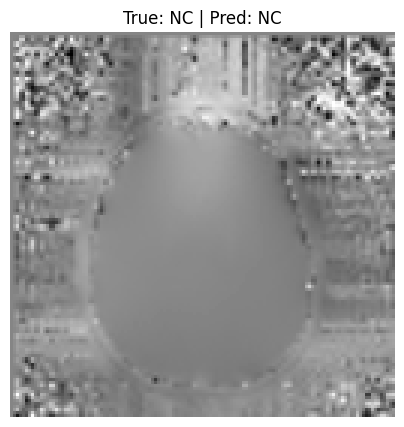

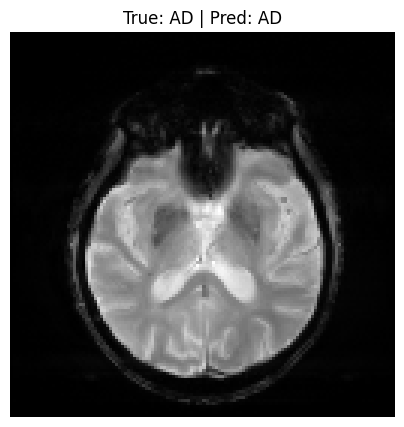

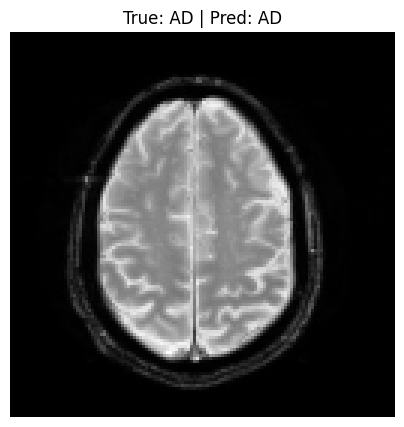

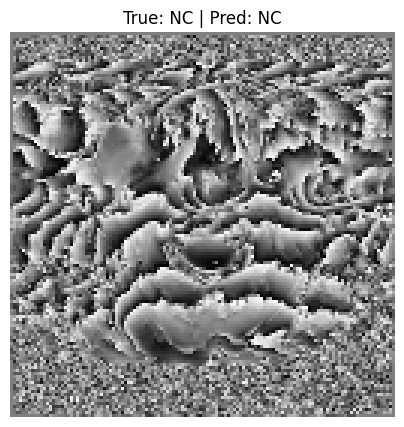

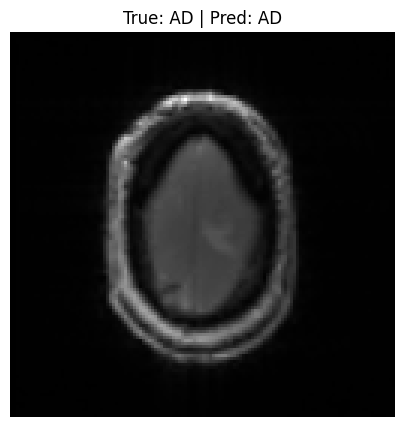

In [57]:
import matplotlib.pyplot as plt
import random

# Set model to evaluation mode
model.eval()

# Select 5 random test samples
indices = random.sample(range(len(test_dataset)), 5)

for idx in indices:
    img, label = test_dataset[idx]  # img: [C,D,H,W] or [C,H,W]
    
    # Move to device and add batch dim
    input_img = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_img)
        _, pred = torch.max(output, 1)
        pred_label = pred.item()
    
    # Convert tensor to numpy for plotting
    img_np = img.squeeze().cpu().numpy()
    
    # Show middle slice
    if img_np.ndim == 3:
        mid_slice = img_np.shape[0] // 2
        img_to_show = img_np[mid_slice,:,:]
    else:  # 2D image
        img_to_show = img_np
    
    plt.figure(figsize=(5,5))
    plt.imshow(img_to_show, cmap='gray')
    plt.title(f"True: {'AD' if label==1 else 'NC'} | Pred: {'AD' if pred_label==1 else 'NC'}")
    plt.axis('off')
    plt.show()
